# Autoencoder Baseline for DCASE‑Inspired Anomalous Sound Detection  
We convert audio to log‑mel spectrograms, train a simple fully‑connected Autoencoder only on **normal** sounds, and use reconstruction error as the anomaly score.


In [1]:
# pip install librosa

In [ ]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version (runtime):", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. PyTorch is using CPU.")


Torch version: 2.7.0+cu126
CUDA available: True
CUDA version (runtime): 12.6
GPU: NVIDIA GeForce RTX 4090


In [3]:
# Install (if in Colab/Kaggle) and import libs
# !pip install librosa tqdm scikit-learn --quiet

import os, glob, json, random, math, time, warnings
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

warnings.filterwarnings("ignore")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# DATA Examination

Train samples: 2370
Test  samples: 1101
First 3 train files: ['DATA/dev_data/dev_data/slider/train\\normal_id_00_00000000.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000001.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000002.wav']


calc duration: 100%|██████████| 2370/2370 [00:21<00:00, 108.23it/s]


Total train duration: 6.58 h


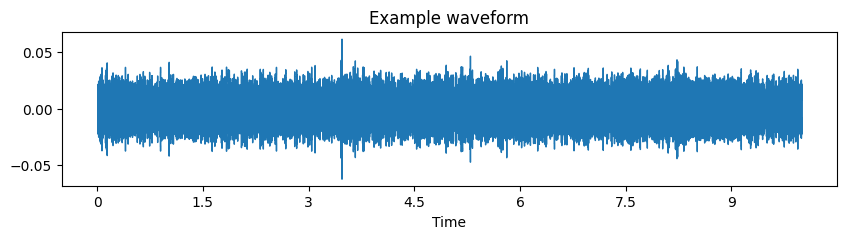

In [4]:
from IPython.display import Audio
# Quick sanity check: list few files and compute total duration of train set
TRAIN_DIR = "DATA/dev_data/dev_data/slider/train"
TEST_DIR  = "DATA/dev_data/dev_data/slider/test"

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.wav")))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  "*.wav")))

print("Train samples:", len(train_files))
print("Test  samples:", len(test_files))
print("First 3 train files:", train_files[:3])

def seconds(path):
    return librosa.get_duration(path=path)
total_sec = sum(seconds(f) for f in tqdm(train_files, desc="calc duration"))
print(f"Total train duration: {total_sec/3600:.2f} h")

# Plot waveform of one example
y, sr = librosa.load(train_files[0], sr=None)
plt.figure(figsize=(10,2)); librosa.display.waveshow(y, sr=sr); plt.title("Example waveform");
Audio(y, rate=sr)

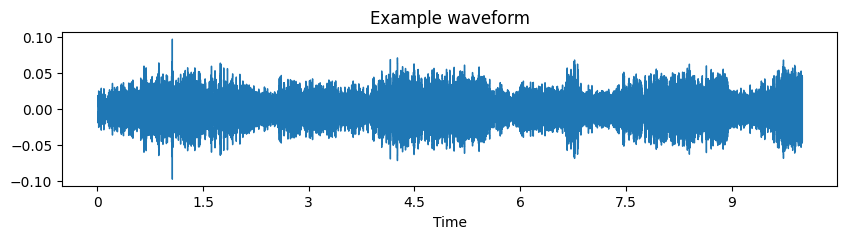

In [5]:
# Plot waveform of one example
y, sr = librosa.load(test_files[10], sr=None)
plt.figure(figsize=(10,2)); librosa.display.waveshow(y, sr=sr); plt.title("Example waveform");
Audio(y, rate=sr)

## Audio → log‑mel conversion
We fix  
* `sample_rate = 16 kHz`  
* `n_mels = 64`  
* pad / truncate to **128 frames** (~4 s).


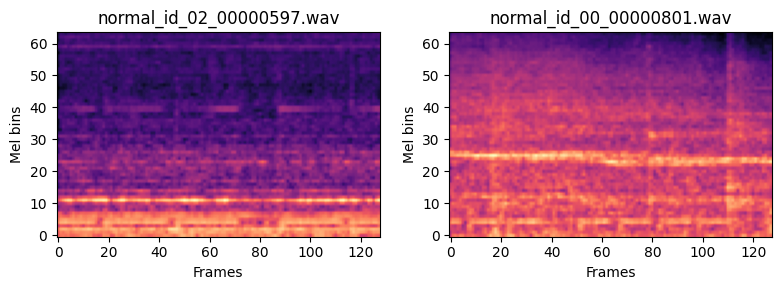

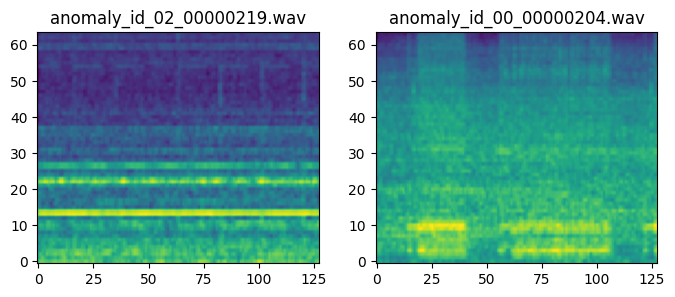

In [6]:
SAMPLE_RATE = 16_000
N_MELS = 64
HOP = 512
FRAMES = 128  # target time steps (~4 seconds)

def audio_to_logmel(path, sr=SAMPLE_RATE):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP)
    logmel = librosa.power_to_db(mel)
    
    # Frame-wise pad/trim
    logmel = logmel.T  # shape: [Time, Mel]
    if logmel.shape[0] < FRAMES:
        pad = FRAMES - logmel.shape[0]
        logmel = np.pad(logmel, ((0, pad), (0, 0)))
    else:
        logmel = logmel[:FRAMES]
    
    # Normalize to 0-1
    logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
    return logmel

# Show spectrograms of 2 random training samples
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, p in enumerate(random.sample(train_files, 2)):
    lm = audio_to_logmel(p)
    ax[i].imshow(lm.T, origin='lower', aspect='auto', cmap='magma')
    ax[i].set_title(os.path.basename(p))
    ax[i].set_xlabel("Frames")
    ax[i].set_ylabel("Mel bins")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8,3))
for i,p in enumerate(random.sample(test_files,2)):
    lm = audio_to_logmel(p)
    ax[i].imshow(lm.T, origin='lower', aspect='auto'); ax[i].set_title(os.path.basename(p));


## Torch Dataset / DataLoader


In [14]:
class SoundDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        lm = audio_to_logmel(self.paths[idx])
        return torch.tensor(lm, dtype=torch.float32).flatten(), self.paths[idx]

BATCH = 512
train_ds = SoundDataset(train_files)
test_ds  = SoundDataset(test_files)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, num_workers=0)


In [ ]:
import torch
# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Using device: cuda
Torch version: 2.7.0+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 4090


In [15]:
## Fully‑connected Autoencoder
INPUT_DIM = FRAMES * N_MELS  # 8192
HIDDEN = 1024

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(INPUT_DIM, HIDDEN), nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(HIDDEN, INPUT_DIM), nn.ReLU())
    def forward(self,x): return self.dec(self.enc(x))

model = AE().to(DEVICE)


In [17]:
## Training loop
EPOCHS = 100
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
history = []

for ep in range(1, EPOCHS+1):
    model.train(); epoch_loss = 0
    for x,_ in tqdm(train_dl, desc=f"Epoch {ep}/{EPOCHS}"):
        x = x.to(DEVICE)
        loss = crit(model(x), x)
        opt.zero_grad(); loss.backward(); opt.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_dl)
    history.append(epoch_loss)
    print(f"Epoch {ep} mean loss {epoch_loss:.4f}")


Epoch 1/100: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 1 mean loss 0.0999


Epoch 2/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 2 mean loss 0.0896


Epoch 3/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 3 mean loss 0.0842


Epoch 4/100: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 4 mean loss 0.0813


Epoch 5/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 5 mean loss 0.0803


Epoch 6/100: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 6 mean loss 0.0798


Epoch 7/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 7 mean loss 0.0794


Epoch 8/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 8 mean loss 0.0790


Epoch 9/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 9 mean loss 0.0791


Epoch 10/100: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 10 mean loss 0.0790


Epoch 11/100: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 11 mean loss 0.0789


Epoch 12/100: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 12 mean loss 0.0787


Epoch 13/100: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 13 mean loss 0.0788


Epoch 14/100: 100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Epoch 14 mean loss 0.0787


Epoch 15/100: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Epoch 15 mean loss 0.0785


Epoch 16/100: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


Epoch 16 mean loss 0.0784


Epoch 17/100: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 17 mean loss 0.0783


Epoch 18/100: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Epoch 18 mean loss 0.0781


Epoch 19/100: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


Epoch 19 mean loss 0.0780


Epoch 20/100: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Epoch 20 mean loss 0.0778


Epoch 21/100: 100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 21 mean loss 0.0778


Epoch 22/100: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Epoch 22 mean loss 0.0778


Epoch 23/100: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


Epoch 23 mean loss 0.0774


Epoch 24/100: 100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


Epoch 24 mean loss 0.0769


Epoch 25/100: 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


Epoch 25 mean loss 0.0769


Epoch 26/100: 100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


Epoch 26 mean loss 0.0765


Epoch 27/100: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 27 mean loss 0.0758


Epoch 28/100: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 28 mean loss 0.0752


Epoch 29/100: 100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


Epoch 29 mean loss 0.0750


Epoch 30/100: 100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 30 mean loss 0.0745


Epoch 31/100: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 31 mean loss 0.0741


Epoch 32/100: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 32 mean loss 0.0736


Epoch 33/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 33 mean loss 0.0733


Epoch 34/100: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 34 mean loss 0.0729


Epoch 35/100: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


Epoch 35 mean loss 0.0727


Epoch 36/100: 100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Epoch 36 mean loss 0.0722


Epoch 37/100: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


Epoch 37 mean loss 0.0718


Epoch 38/100: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 38 mean loss 0.0717


Epoch 39/100: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 39 mean loss 0.0705


Epoch 40/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 40 mean loss 0.0699


Epoch 41/100: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 41 mean loss 0.0694


Epoch 42/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 42 mean loss 0.0692


Epoch 43/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 43 mean loss 0.0688


Epoch 44/100: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]


Epoch 44 mean loss 0.0685


Epoch 45/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 45 mean loss 0.0681


Epoch 46/100: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]


Epoch 46 mean loss 0.0678


Epoch 47/100: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 47 mean loss 0.0677


Epoch 48/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 48 mean loss 0.0673


Epoch 49/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 49 mean loss 0.0670


Epoch 50/100: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


Epoch 50 mean loss 0.0668


Epoch 51/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 51 mean loss 0.0668


Epoch 52/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 52 mean loss 0.0662


Epoch 53/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 53 mean loss 0.0658


Epoch 54/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 54 mean loss 0.0655


Epoch 55/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 55 mean loss 0.0651


Epoch 56/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 56 mean loss 0.0651


Epoch 57/100: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 57 mean loss 0.0650


Epoch 58/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 58 mean loss 0.0648


Epoch 59/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 59 mean loss 0.0646


Epoch 60/100: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 60 mean loss 0.0644


Epoch 61/100: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 61 mean loss 0.0643


Epoch 62/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 62 mean loss 0.0640


Epoch 63/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 63 mean loss 0.0639


Epoch 64/100: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 64 mean loss 0.0638


Epoch 65/100: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 65 mean loss 0.0636


Epoch 66/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 66 mean loss 0.0638


Epoch 67/100: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


Epoch 67 mean loss 0.0641


Epoch 68/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 68 mean loss 0.0634


Epoch 69/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 69 mean loss 0.0631


Epoch 70/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 70 mean loss 0.0630


Epoch 71/100: 100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


Epoch 71 mean loss 0.0629


Epoch 72/100: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


Epoch 72 mean loss 0.0629


Epoch 73/100: 100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


Epoch 73 mean loss 0.0628


Epoch 74/100: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 74 mean loss 0.0628


Epoch 75/100: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 75 mean loss 0.0627


Epoch 76/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 76 mean loss 0.0627


Epoch 77/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 77 mean loss 0.0626


Epoch 78/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 78 mean loss 0.0625


Epoch 79/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 79 mean loss 0.0625


Epoch 80/100: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 80 mean loss 0.0625


Epoch 81/100: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 81 mean loss 0.0623


Epoch 82/100: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 82 mean loss 0.0623


Epoch 83/100: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Epoch 83 mean loss 0.0620


Epoch 84/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 84 mean loss 0.0621


Epoch 85/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 85 mean loss 0.0620


Epoch 86/100: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 86 mean loss 0.0619


Epoch 87/100: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 87 mean loss 0.0617


Epoch 88/100: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


Epoch 88 mean loss 0.0612


Epoch 89/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 89 mean loss 0.0611


Epoch 90/100: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


Epoch 90 mean loss 0.0610


Epoch 91/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 91 mean loss 0.0607


Epoch 92/100: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 92 mean loss 0.0608


Epoch 93/100: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Epoch 93 mean loss 0.0609


Epoch 94/100: 100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Epoch 94 mean loss 0.0600


Epoch 95/100: 100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Epoch 95 mean loss 0.0598


Epoch 96/100: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 96 mean loss 0.0596


Epoch 97/100: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 97 mean loss 0.0594


Epoch 98/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 98 mean loss 0.0593


Epoch 99/100: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 99 mean loss 0.0591


Epoch 100/100: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]

Epoch 100 mean loss 0.0591


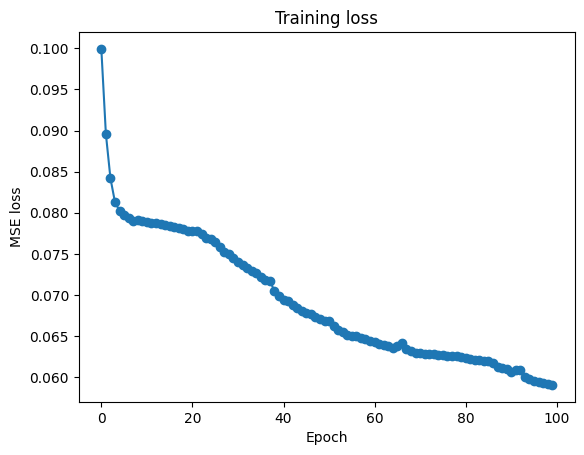

In [19]:
## Loss curve
plt.figure(); plt.plot(history, marker='o'); plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("Training loss");


In [20]:
## Inference & AUC evaluation
model.eval(); scores, labels = [], []
with torch.no_grad():
    for x, paths in tqdm(test_dl, desc="Infer"):
        x = x.to(DEVICE)
        err = torch.mean((x - model(x))**2, dim=1).cpu().numpy()
        scores.extend(err)
        labels += [1 if "anomaly" in p.lower() else 0 for p in paths]

auc = roc_auc_score(labels, scores)
print("AUC:", round(auc,4))


Infer: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]

AUC: 0.6131


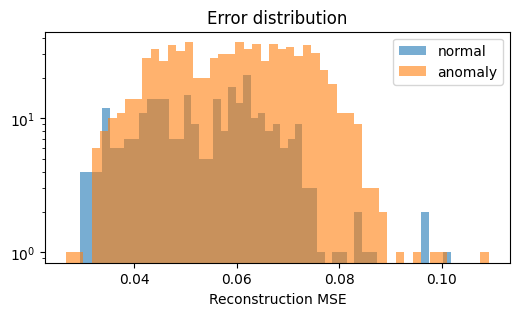

In [13]:
normal_err = [s for s,l in zip(scores,labels) if l==0]
anom_err   = [s for s,l in zip(scores,labels) if l==1]

plt.figure(figsize=(6,3))
plt.hist(normal_err, bins=50, alpha=0.6, label="normal")
plt.hist(anom_err,   bins=50, alpha=0.6, label="anomaly")
plt.yscale('log'); plt.legend(); plt.xlabel("Reconstruction MSE"); plt.title("Error distribution");
